# Malicious ClusterScan

Describes/summarizes the or set of clusters. Useful for when you aim to enlist the summarized malware types found in each cluster in order by Type # as presented in VirusTotal such that the first ones on the list per cluster are Type 1 (most popular), followed by Type 2 then Type 3 (least popular).

Note that this notebook only makes use of the verified xxxx_SampleHash_Common.csv file which represents a significant majority of the entire Oliveira dataset.  

## Import Libraries/Datasets

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

malicious_df = pd.read_csv('./Clustering/(EDITED)KMeans_SampleHash_Common.csv', low_memory=False, index_col=False) #This should point to a VirusTotal verified <Data Clustering>_SampleHash_Common.csv file

#Load list of API calls
API_LIST = "api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

def get_unique_clusters(df:pd.DataFrame):
    return list(df['cluster'].unique())

## DataFrame Preview

In [96]:
#Replace '-' empty malware type delimiter with '_' for consistency
malicious_df.replace(to_replace='-',value='_', inplace=True)
malicious_df

,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,490d584c7d303ed35c673460b63f3ca8,trojan,dropper,pua,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
1,0,9ab8ea1d2d68a0d4110df413e677976c,trojan,hacktool,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
2,0,adbc74815ef2bd1ea4967abad812233d,trojan,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
3,0,f6eb4841bba3a4cee747700dc0ee1609,_,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
4,0,f5a0ad49337ebc87897698e70d03364e,trojan,dropper,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst..."
...,...,...,...,...,...,...
1756,198,d24b78bd73f17379ed62e4c776b4f66e,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1757,198,f666dd4b3a53b7fe71f8976fa09bfdfb,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
1758,199,b6d6520b608875282d831b1e983cd5e5,_,_,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1759,199,18bce1a594550daf8b3f318de48c1674,trojan,dropper,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."


In [97]:
def list_to_str(ls:list):
    output = ""
    for l in ls:
        output += str(l) + " "
    return output[0:len(output)-1]

def inject_patterns(inner_df:pd.DataFrame):
    patterns = []
    for row in range(inner_df.shape[0]):
        patterns.append(list_to_str(inner_df.iloc[row,2:5].transpose().to_list()))
    inner_df['type_pattern'] = patterns
    return inner_df
malicious_df = inject_patterns(malicious_df)

In [98]:
#Drop row that is falsely labelled. (i.e. '_' on all popularity levels of VirusTotal)
malicious_df.drop(malicious_df[(malicious_df['Type 1']=='_')&(malicious_df['Type 2']=='_')&(malicious_df['Type 3']=='_')].index, inplace=True)
malicious_df

,cluster,hash,Type 1,Type 2,Type 3,pattern,type_pattern
0,0,490d584c7d303ed35c673460b63f3ca8,trojan,dropper,pua,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst...",trojan dropper pua
1,0,9ab8ea1d2d68a0d4110df413e677976c,trojan,hacktool,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst...",trojan hacktool _
2,0,adbc74815ef2bd1ea4967abad812233d,trojan,_,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst...",trojan _ _
4,0,f5a0ad49337ebc87897698e70d03364e,trojan,dropper,_,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst...",trojan dropper _
5,0,4c972b447659f1e86769eb43593fd2a5,trojan,downloader,dropper,"GetSystemTimeAsFileTime,NtCreateMutant,GetSyst...",trojan downloader dropper
...,...,...,...,...,...,...,...
1755,198,0226e311ed2648ff399c7902fc113421,adware,trojan,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",adware trojan _
1756,198,d24b78bd73f17379ed62e4c776b4f66e,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",trojan adware _
1757,198,f666dd4b3a53b7fe71f8976fa09bfdfb,trojan,adware,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",trojan adware _
1759,199,18bce1a594550daf8b3f318de48c1674,trojan,dropper,_,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr...",trojan dropper _


## "What Malware Types can be found in the dataset?"

How many instances of a certain malware type are there in the entire dataset per Type # (indicating popularity) as specified by VirusTotal (VT)?

Such findings may also be used as a reflection as to what malware types are most prevalent in the wild.

In [99]:
display(malicious_df['Type 1'].value_counts())
display(malicious_df['Type 2'].value_counts())
display(malicious_df['Type 3'].value_counts())

Type 1
trojan         1340
adware          195
downloader       78
ransomware       19
miner            14
dropper           4
pua               3
nsismod           3
virus             1
hacktool          1
avaquest          1
opencandy         1
syncopate         1
techjoydown       1
msil              1
fugrafa           1
Name: count, dtype: int64

Type 2
adware        846
_             312
trojan        228
downloader     77
dropper        71
pua            31
miner          26
spyware        21
ransomware     17
virus          13
banker         12
worm            7
hacktool        1
candyopen       1
nsismod         1
Name: count, dtype: int64

Type 3
_             1065
pua            171
virus          135
downloader     115
trojan          61
adware          55
dropper         45
spyware          7
ransomware       4
hacktool         3
banker           2
worm             1
Name: count, dtype: int64

<BarContainer object of 12 artists>

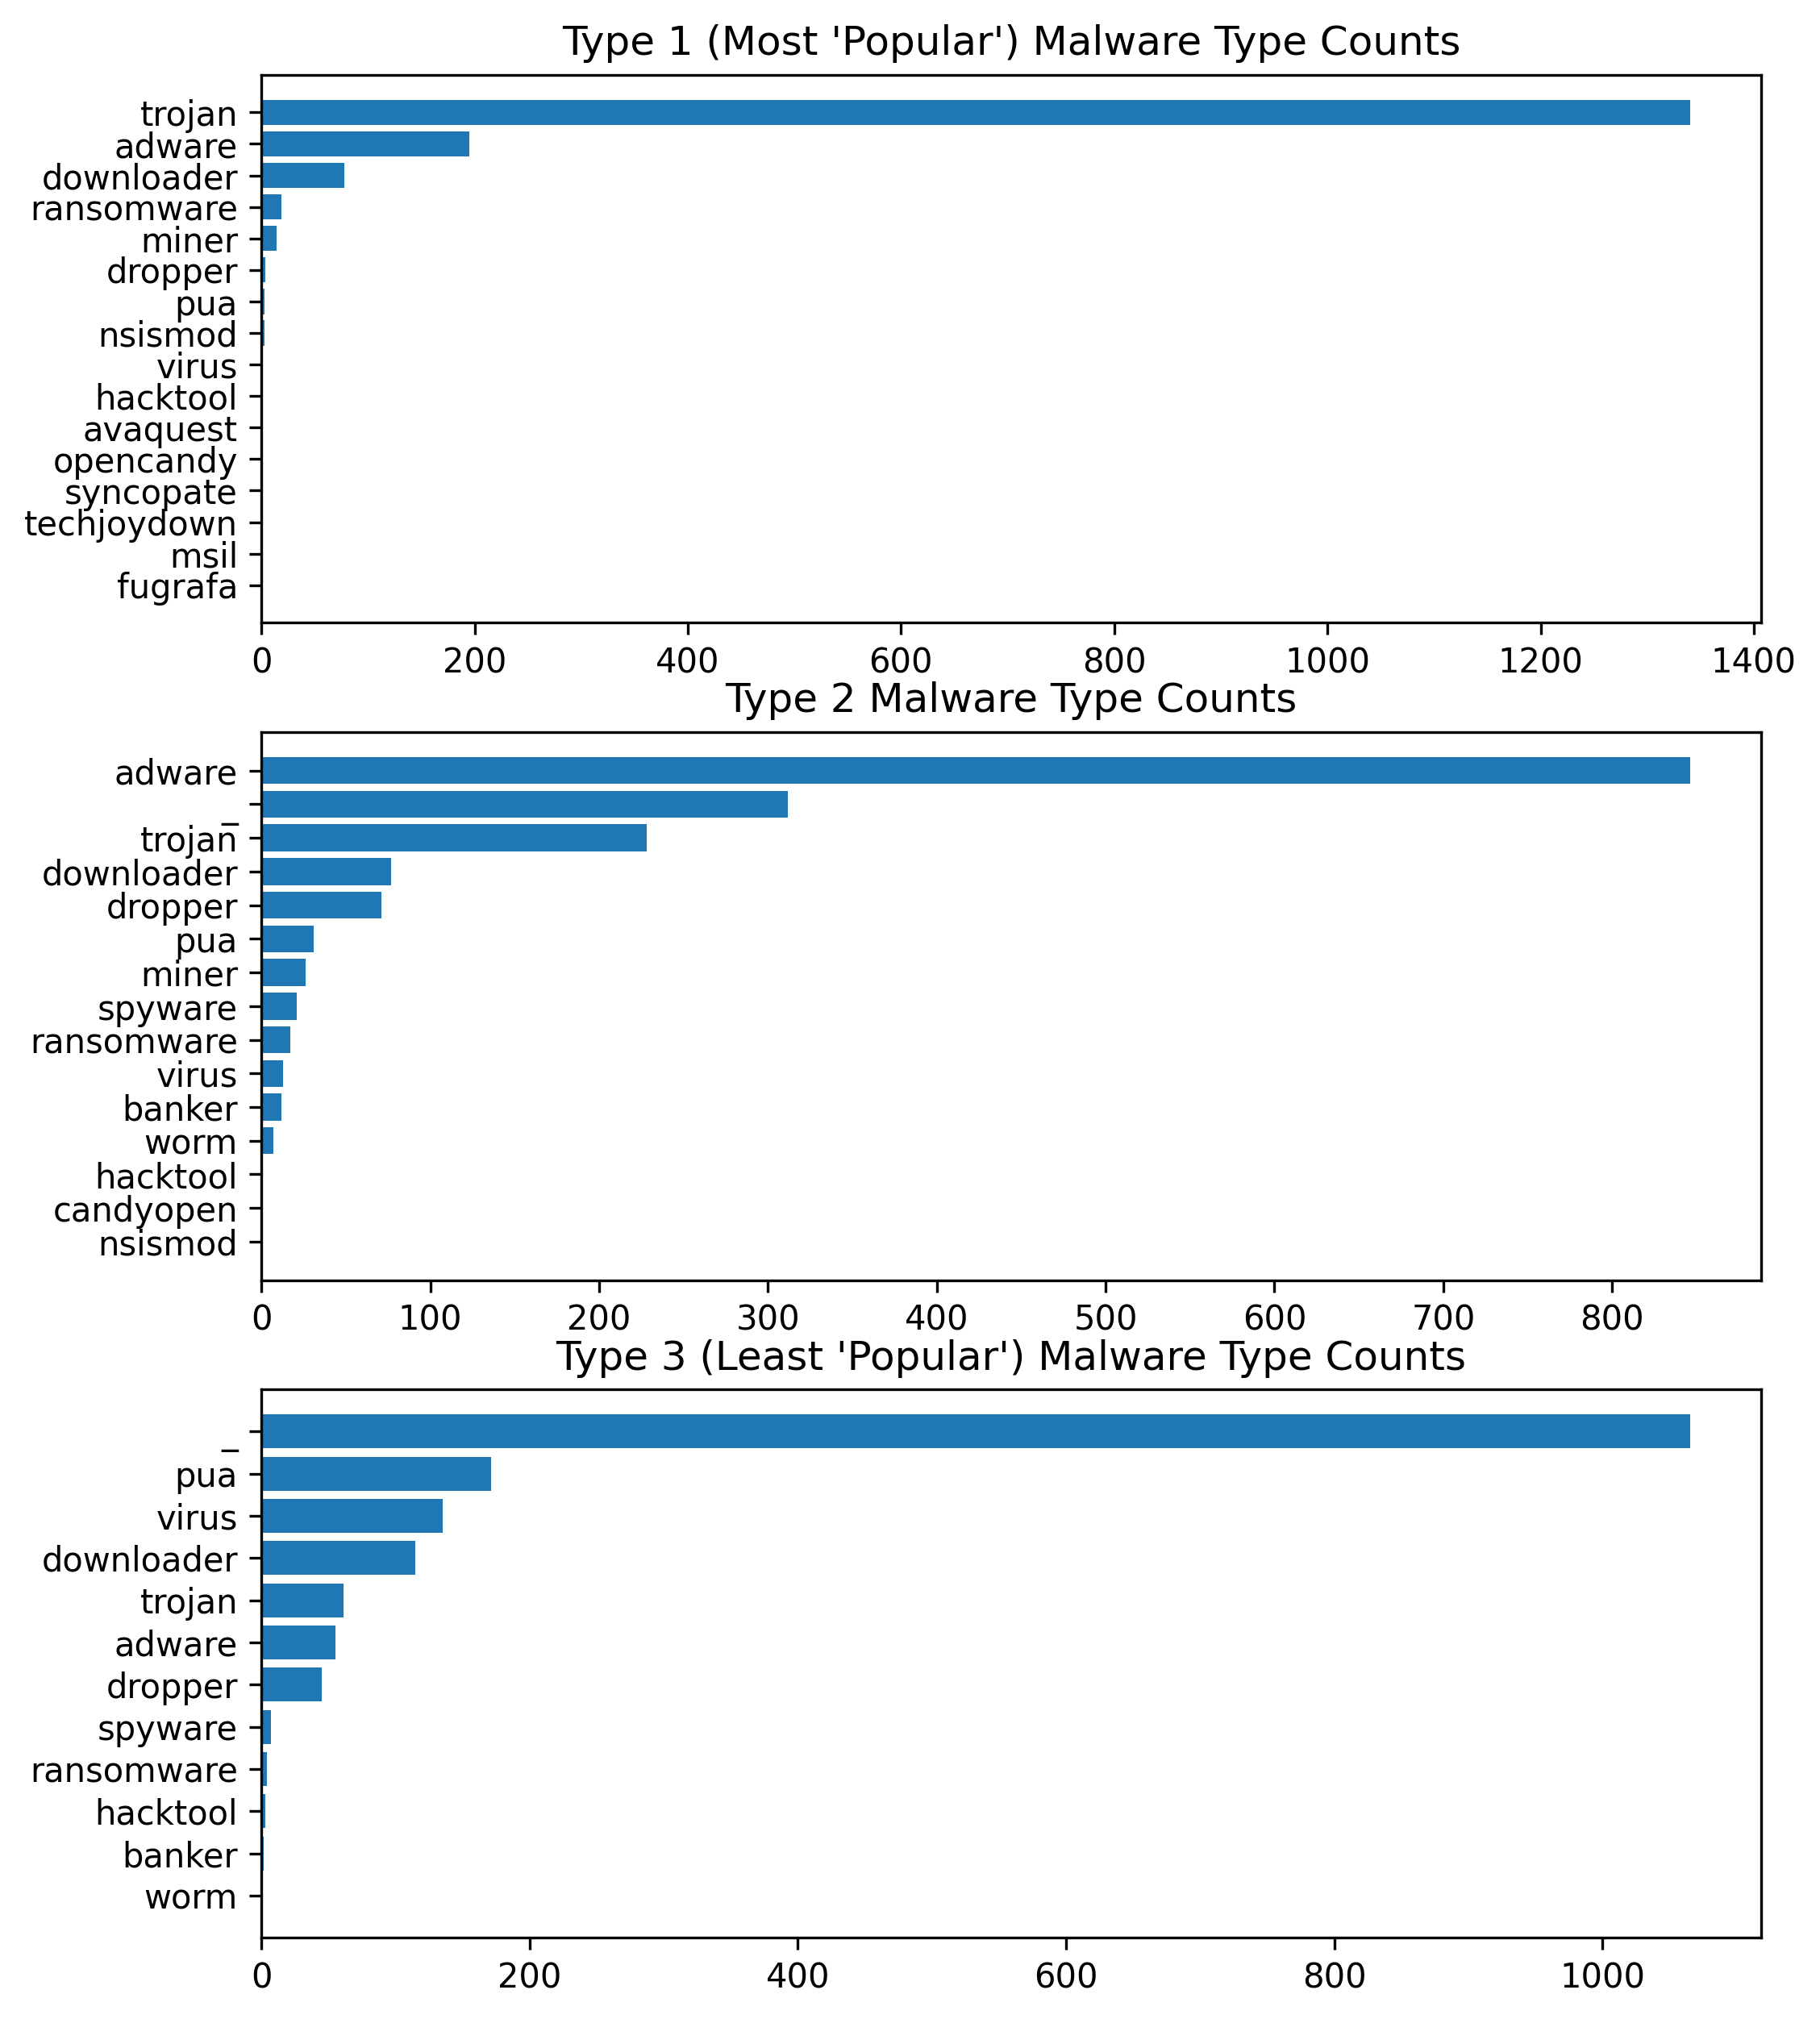

In [100]:
fig, axs = plt.subplots(3)
fig.set_figwidth(8)
fig.set_figheight(10)
fig.set_dpi(300)
axs[0].set_title('Type 1 (Most \'Popular\') Malware Type Counts')
axs[0].barh(malicious_df['Type 1'].value_counts().index, malicious_df['Type 1'].value_counts())
axs[0].invert_yaxis()
axs[1].set_title('Type 2 Malware Type Counts')
axs[1].invert_yaxis()
axs[1].barh(malicious_df['Type 2'].value_counts().index, malicious_df['Type 2'].value_counts())
axs[2].invert_yaxis()
axs[2].set_title('Type 3 (Least \'Popular\') Malware Type Counts')
axs[2].barh(malicious_df['Type 3'].value_counts().index, malicious_df['Type 3'].value_counts())

## "What Malware Types are there in each cluster?"

This indicates what are the individual malware types mostly associated to cluster in terms of quantity regardless of order by popularity by VT.

Note that order matters as the first ones are the most popular labels as indicated by VT.

In [101]:
#Identify the overall list of types each cluster is as designated by VirusTotal.
unique_clusters = get_unique_clusters(malicious_df)

type_cols = ['Type 1', 'Type 2', 'Type 3']
summary = []
'''
Structure of summary[]

summary[0] = index (int)
summary[1] = Type 1 malware type (Most 'Popular' classification by AVs)
summary[2] = Type 2 malware type (2nd Most 'Popular' classification by AVs)
summary[3] = Type 3 malware type (Least Most 'Popular' classification by AVs)
summary[4] = Most Popular Combination (in single string form)

'''
for u in unique_clusters:
    cluster_sublist = [u]
    df_copy = malicious_df[malicious_df['cluster'] == u].copy(deep=True)
    for t in type_cols:
        type_sublist = []
        idx = list(df_copy[t].value_counts().index)
        counts = list(df_copy[t].value_counts())
        for i in range(len(idx)):
            type_sublist.append([idx[i], counts[i]])
        cluster_sublist.append(type_sublist)
    str_summary = []
    cluster_sublist.append(list(df_copy['type_pattern'].value_counts().index))
    cluster_sublist.append(list(df_copy['type_pattern'].value_counts()))
    summary.append(cluster_sublist)

### Identify the counts of Malware Types per Cluster (by Type #) & the Most Popular Malware Type Combination on said Cluster.

This indicates the malware types (including the # of instances) and malware type combinations (including the # of instances) found in each cluster.

*It is recommended for the output data in this code block to be converted into a table.*

In [102]:
for s in summary:
    print("CLUSTER:", s[0])
    print("\tType 1:")
    for t in s[1]:
        print(f"\t\t{t[0]:12s} ({t[1]})")
    print("\tType 2:")
    for t in s[2]:
        print(f"\t\t{t[0]:12s} ({t[1]})")
    print("\tType 3:")
    for t in s[3]:
        print(f"\t\t{t[0]:12s} ({t[1]})")
    print("\tMost Popular Malware Type Combination\n\t(in order Most to Least):")
    for i,t in enumerate(s[4]):
        print(f"\t\t{t} ({s[5][i]})")
    print("")

CLUSTER: 0
	Type 1:
		trojan       (9)
	Type 2:
		dropper      (4)
		_            (2)
		downloader   (2)
		hacktool     (1)
	Type 3:
		_            (5)
		pua          (2)
		dropper      (2)
	Most Popular Malware Type Combination
	(in order Most to Least):
		trojan dropper pua (2)
		trojan _ _ (2)
		trojan dropper _ (2)
		trojan downloader dropper (2)
		trojan hacktool _ (1)

CLUSTER: 1
	Type 1:
		trojan       (5)
	Type 2:
		pua          (5)
	Type 3:
		_            (4)
		adware       (1)
	Most Popular Malware Type Combination
	(in order Most to Least):
		trojan pua _ (4)
		trojan pua adware (1)

CLUSTER: 2
	Type 1:
		trojan       (10)
	Type 2:
		adware       (10)
	Type 3:
		_            (5)
		pua          (3)
		downloader   (1)
		dropper      (1)
	Most Popular Malware Type Combination
	(in order Most to Least):
		trojan adware _ (5)
		trojan adware pua (3)
		trojan adware downloader (1)
		trojan adware dropper (1)

CLUSTER: 3
	Type 1:
		downloader   (4)
		trojan       (3)
		adware      

### Identify the Clusters that have the same Unique Malware Type Combinations

This indicates what clusters have verified malicious samples that match specific Malware Type Combinations.

This indicates the most occuring Malware Type Combination which extends to the most 'popular' malware type that is probably found in the dataset.

Such findings may also be used as a reflection as to what malware types are most prevalent in the wild.

In [103]:
# Summarize Clusters that have the same malware types as per VirusTotal.
unique_type_summary = list(malicious_df['type_pattern'].unique())
print("# of Unique Malware Type Combinations:", len(unique_type_summary),"\n")

cluster_instance_summary = [0] * len(list(malicious_df['cluster'].unique()))
count_summary = []
for i, u in enumerate(list(malicious_df['type_pattern'].unique())):
    matching = malicious_df[malicious_df['type_pattern'] == u]['cluster']
    count_summary.append([u, len(list(matching)), len(list(matching.unique()))])
    print(f"Unique Malware Type Combination: {i+1}".upper())
    print("Malware Type Combination:", u)
    print("Matching Clusters:", list(matching.unique()))
    print("Matching Clusters Count:", len(list(matching.unique())))
    print("")

count_summary.sort(key=lambda x: x[1])
count_summary = pd.DataFrame(count_summary, columns=['Malware Type Combination', 'No. of Matching Verified Samples', 'No. of Matching Clusters'])

count_summary.sort_values(by='No. of Matching Clusters',ascending=False, inplace=True)
display("Top 10 Most Common Malware Type Combination (by Cluster Count)")
display(count_summary[['Malware Type Combination','No. of Matching Clusters']].iloc[0:10])

count_summary.sort_values(by='No. of Matching Clusters',ascending=True, inplace=True)
display("Top 10 Least Common Malware Types Combination (by Cluster Count)")
display(count_summary[['Malware Type Combination','No. of Matching Clusters']].iloc[0:10])

# of Unique Malware Type Combinations: 82 

UNIQUE MALWARE TYPE COMBINATION: 1
Malware Type Combination: trojan dropper pua
Matching Clusters: [0, 109, 139]
Matching Clusters Count: 3

UNIQUE MALWARE TYPE COMBINATION: 2
Malware Type Combination: trojan hacktool _
Matching Clusters: [0]
Matching Clusters Count: 1

UNIQUE MALWARE TYPE COMBINATION: 3
Malware Type Combination: trojan _ _
Matching Clusters: [0, 3, 4, 16, 18, 19, 23, 26, 29, 30, 31, 32, 37, 39, 46, 47, 49, 51, 53, 54, 55, 59, 60, 63, 65, 67, 69, 72, 73, 74, 80, 81, 82, 87, 88, 92, 96, 97, 102, 108, 109, 114, 117, 118, 120, 121, 123, 125, 126, 138, 139, 140, 141, 143, 144, 147, 148, 152, 155, 156, 158, 162, 163, 170, 172, 175, 176, 190, 192, 193, 195, 196, 198]
Matching Clusters Count: 73

UNIQUE MALWARE TYPE COMBINATION: 4
Malware Type Combination: trojan dropper _
Matching Clusters: [0, 4, 23, 30, 46, 53, 54, 55, 59, 80, 82, 92, 102, 121, 138, 139, 140, 143, 155, 165, 176, 192, 198, 199]
Matching Clusters Count: 24

UNIQUE 

'Top 10 Most Common Malware Type Combination (by Cluster Count)'

,Malware Type Combination,No. of Matching Clusters
81,trojan adware _,95
80,trojan _ _,73
79,trojan adware pua,37
78,trojan adware virus,29
77,trojan adware downloader,25
76,trojan dropper _,24
72,adware trojan _,20
75,adware trojan virus,19
70,trojan adware dropper,19
71,trojan downloader adware,15


'Top 10 Least Common Malware Types Combination (by Cluster Count)'

,Malware Type Combination,No. of Matching Clusters
11,trojan dropper adware,1
2,trojan miner adware,1
3,pua trojan adware,1
4,virus trojan adware,1
5,trojan virus adware,1
6,trojan adware hacktool,1
7,pua adware trojan,1
8,hacktool pua trojan,1
20,trojan dropper hacktool,1
21,pua trojan _,1


### Identify the no. of samples that have the same Unique Malware Type Combinations

This indicates how many samples have the same Malware Type Combinations.

The Malware Type Combination with the highest number of clusters should be backed-up by the results in the next item.

The findings below support the results found in both items above.

It is not expected that the results shown below are the same as the one shown above. Nevertheless, it will show consensus as to what is most and least popular in terms of Malware Type Combination.

In [104]:
count_summary.sort_values(by='No. of Matching Verified Samples',ascending=False, inplace=True)
display("Top 10 Most Common Malware Type Combination (by Samples)")
display(count_summary[['Malware Type Combination','No. of Matching Verified Samples']].iloc[0:10])

count_summary.sort_values(by='No. of Matching Verified Samples',ascending=True, inplace=True)
display("Top 10 Least Common Malware Types Combination (by Samples)")
display(count_summary[['Malware Type Combination','No. of Matching Verified Samples']].iloc[0:10])

'Top 10 Most Common Malware Type Combination (by Samples)'

,Malware Type Combination,No. of Matching Verified Samples
81,trojan adware _,517
80,trojan _ _,294
79,trojan adware pua,126
78,trojan adware virus,80
77,trojan adware downloader,57
76,trojan dropper _,54
75,adware trojan virus,51
74,adware trojan downloader,44
73,downloader adware trojan,39
72,adware trojan _,33


'Top 10 Least Common Malware Types Combination (by Samples)'

,Malware Type Combination,No. of Matching Verified Samples
24,techjoydown _ _,1
11,trojan dropper adware,1
2,trojan miner adware,1
0,trojan hacktool _,1
3,pua trojan adware,1
4,virus trojan adware,1
5,trojan virus adware,1
6,trojan adware hacktool,1
7,pua adware trojan,1
8,hacktool pua trojan,1


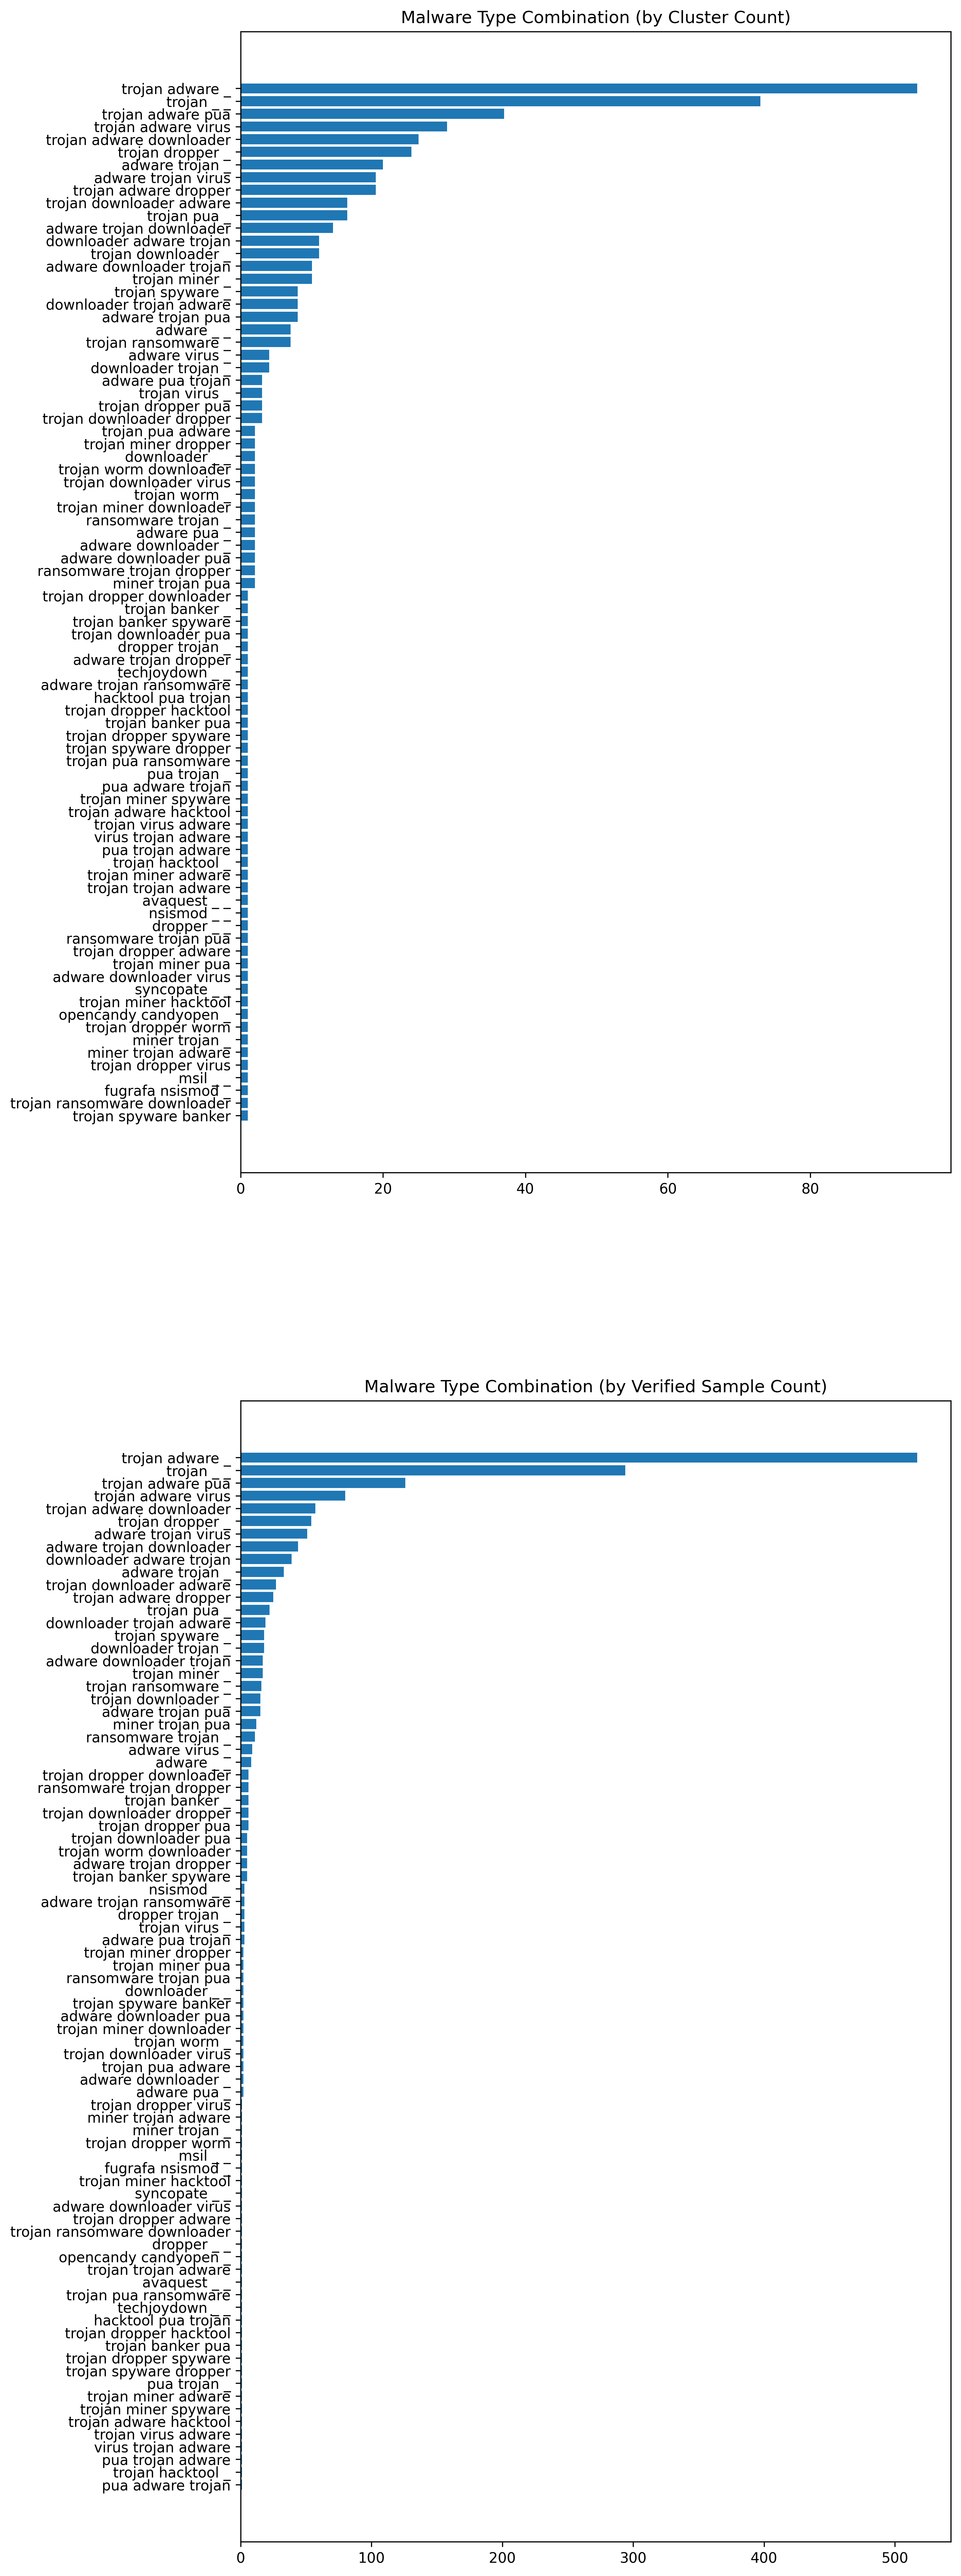

In [105]:
fig, axs = plt.subplots(2)
fig.set_figwidth(9)
fig.set_figheight(32)
fig.set_dpi(300)
count_summary.sort_values(by='No. of Matching Clusters',ascending=False, inplace=True)
axs[0].set_title('Malware Type Combination (by Cluster Count)')
axs[0].barh(count_summary['Malware Type Combination'], count_summary['No. of Matching Clusters'])
axs[0].invert_yaxis()
count_summary.sort_values(by='No. of Matching Verified Samples',ascending=False, inplace=True)
axs[1].set_title('Malware Type Combination (by Verified Sample Count)')
axs[1].barh(count_summary['Malware Type Combination'], count_summary['No. of Matching Verified Samples'])
axs[1].invert_yaxis()